<a href="https://colab.research.google.com/github/AkshayKumarEdayilliam/Deep-Learning-Projects/blob/main/recommendation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [71]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
PATH = '/content/'
ratings = pd.read_csv(PATH + 'ratings.csv')
ratings.head()


,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [72]:
g = ratings.groupby('userId')['rating'].count()
top_users = g.sort_values(ascending=False)[:15]
g = ratings.groupby('movieId')['rating'].count()
top_movies = g.sort_values(ascending=False)[:15]
top_r = ratings.join(top_users, rsuffix='_r', how='inner', on='userId')
top_r = top_r.join(top_movies, rsuffix='_r', how='inner', on='movieId')
pd.crosstab(top_r.userId, top_r.movieId, top_r.rating, aggfunc=np.sum)

movieId,1,50,110,260,296,318,356,480,527,589,593,1196,2571,2858,2959
userId,,,,,,,,,,,,,,,
68,2.5,3.0,2.5,5.0,2.0,3.0,3.5,3.5,4.0,3.5,3.5,5.0,4.5,5.0,2.5
182,4.0,4.5,3.5,3.5,5.0,4.5,5.0,3.5,4.0,2.0,4.5,3.0,5.0,5.0,5.0
249,4.0,4.0,5.0,5.0,4.0,4.5,4.5,4.0,4.5,4.0,4.0,5.0,5.0,4.5,5.0
274,4.0,4.0,4.5,3.0,5.0,4.5,4.5,3.5,4.0,4.5,4.0,4.5,4.0,5.0,5.0
288,4.5,NaN,5.0,5.0,5.0,5.0,5.0,2.0,5.0,4.0,5.0,4.5,3.0,NaN,3.5
307,4.0,4.5,3.5,3.5,4.5,4.5,4.0,3.5,4.5,2.5,4.5,3.0,3.5,4.0,4.0
380,5.0,4.0,4.0,5.0,5.0,3.0,5.0,5.0,NaN,5.0,5.0,5.0,4.5,NaN,4.0
387,NaN,4.5,3.5,4.5,5.0,3.5,4.0,3.0,NaN,3.5,4.0,4.5,4.0,4.5,4.5
414,4.0,5.0,5.0,5.0,5.0,5.0,5.0,4.0,4.0,5.0,4.0,5.0,5.0,5.0,5.0


In [73]:
user_enc = LabelEncoder()
ratings['user'] = user_enc.fit_transform(ratings['userId'].values)
n_users = ratings['user'].nunique()
item_enc = LabelEncoder()
ratings['movie'] = item_enc.fit_transform(ratings['movieId'].values)
n_movies = ratings['movie'].nunique()
ratings['rating'] = ratings['rating'].values.astype(np.float32)
min_rating = min(ratings['rating'])
max_rating = max(ratings['rating'])
n_users, n_movies, min_rating, max_rating

(610, 9724, 0.5, 5.0)

In [74]:
X = ratings[['user', 'movie']].values
y = ratings['rating'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((90752, 2), (10084, 2), (90752,), (10084,))

In [75]:
n_factors = 50
X_train_array = [X_train[:, 0], X_train[:, 1]]
X_test_array = [X_test[:, 0], X_test[:, 1]]

In [76]:
from keras.models import Model
from keras.layers import Input, Reshape, Dot
from keras.layers.embeddings import Embedding
from keras.optimizers import Adam
from keras.regularizers import l2
def RecommenderV1(n_users, n_movies, n_factors):
    user = Input(shape=(1,))
    u = Embedding(n_users, n_factors, embeddings_initializer='he_normal',
                  embeddings_regularizer=l2(1e-6))(user)
    u = Reshape((n_factors,))(u)
    
    movie = Input(shape=(1,))
    m = Embedding(n_movies, n_factors, embeddings_initializer='he_normal',
                  embeddings_regularizer=l2(1e-6))(movie)
    m = Reshape((n_factors,))(m)
    
    x = Dot(axes=1)([u, m])
    model = Model(inputs=[user, movie], outputs=x)
    opt = Adam(learning_rate=0.001)
    model.compile(loss='mean_squared_error', optimizer=opt)
    return model

In [77]:
model = RecommenderV1(n_users, n_movies, n_factors)
model.summary()

Model: "model_10"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_21 (InputLayer)           [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_22 (InputLayer)           [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding_26 (Embedding)        (None, 1, 50)        30500       input_21[0][0]                   
__________________________________________________________________________________________________
embedding_27 (Embedding)        (None, 1, 50)        486200      input_22[0][0]                   
___________________________________________________________________________________________

In [78]:
history = model.fit(x=X_train_array, y=y_train, batch_size=64, epochs=5,
                    verbose=1, validation_data=(X_test_array, y_test))

Epoch 1/5
1418/1418 [==============================] - 8s 5ms/step - loss: 12.1465 - val_loss: 3.1551
Epoch 2/5
1418/1418 [==============================] - 7s 5ms/step - loss: 2.3241 - val_loss: 1.6213
Epoch 3/5
1418/1418 [==============================] - 6s 5ms/step - loss: 1.1506 - val_loss: 1.3610
Epoch 4/5
1418/1418 [==============================] - 6s 4ms/step - loss: 0.8546 - val_loss: 1.2789
Epoch 5/5
1418/1418 [==============================] - 6s 4ms/step - loss: 0.7219 - val_loss: 1.2502


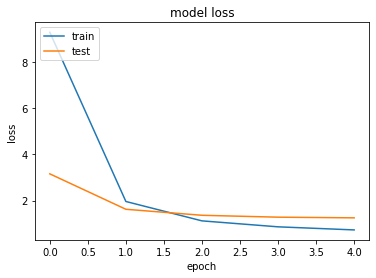

In [79]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "test"], loc="upper left")
plt.show()

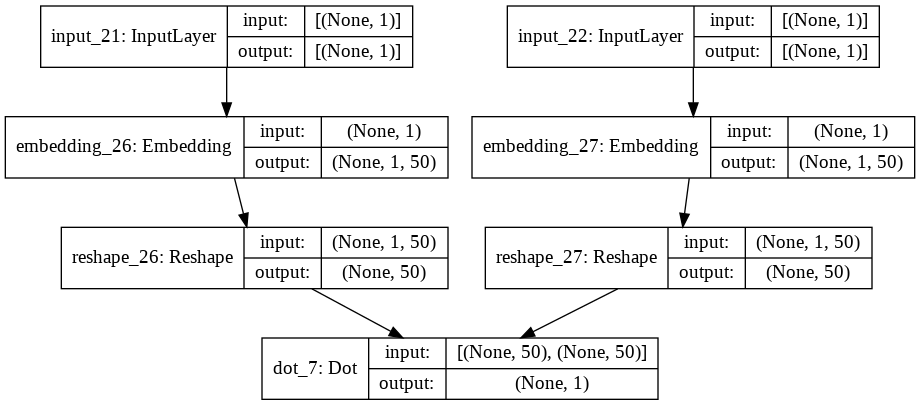

In [80]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='mod1.png', show_shapes=True, show_layer_names=True)

In [81]:
from keras.layers import Add, Activation, Lambda
class EmbeddingLayer:
    def __init__(self, n_items, n_factors):
        self.n_items = n_items
        self.n_factors = n_factors
    
    def __call__(self, x):
        x = Embedding(self.n_items, self.n_factors, embeddings_initializer='he_normal',
                      embeddings_regularizer=l2(1e-6))(x)
        x = Reshape((self.n_factors,))(x)
        return x
def RecommenderV2(n_users, n_movies, n_factors, min_rating, max_rating):
    user = Input(shape=(1,))
    u = EmbeddingLayer(n_users, n_factors)(user)
    ub = EmbeddingLayer(n_users, 1)(user)
    
    movie = Input(shape=(1,))
    m = EmbeddingLayer(n_movies, n_factors)(movie)
    mb = EmbeddingLayer(n_movies, 1)(movie)
    x = Dot(axes=1)([u, m])
    x = Add()([x, ub, mb])
    x = Activation('sigmoid')(x)
    x = Lambda(lambda x: x * (max_rating - min_rating) + min_rating)(x)
    model = Model(inputs=[user, movie], outputs=x)
    opt = Adam(learning_rate=0.001)
    model.compile(loss='mean_squared_error', optimizer=opt)
    return model

In [82]:
model = RecommenderV2(n_users, n_movies, n_factors, min_rating, max_rating)
model.summary()

Model: "model_11"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_23 (InputLayer)           [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_24 (InputLayer)           [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding_28 (Embedding)        (None, 1, 50)        30500       input_23[0][0]                   
__________________________________________________________________________________________________
embedding_30 (Embedding)        (None, 1, 50)        486200      input_24[0][0]                   
___________________________________________________________________________________________

In [83]:
history = model.fit(x=X_train_array, y=y_train, batch_size=64, epochs=5,
                    verbose=1, validation_data=(X_test_array, y_test))

Epoch 1/5
1418/1418 [==============================] - 8s 5ms/step - loss: 1.4363 - val_loss: 0.8575
Epoch 2/5
1418/1418 [==============================] - 6s 4ms/step - loss: 0.7265 - val_loss: 0.7574
Epoch 3/5
1418/1418 [==============================] - 6s 4ms/step - loss: 0.5381 - val_loss: 0.7383
Epoch 4/5
1418/1418 [==============================] - 6s 4ms/step - loss: 0.4035 - val_loss: 0.7444
Epoch 5/5
1418/1418 [==============================] - 6s 4ms/step - loss: 0.3086 - val_loss: 0.7579


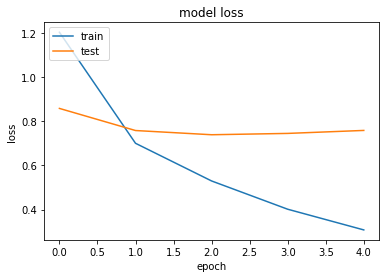

In [84]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "test"], loc="upper left")
plt.show()

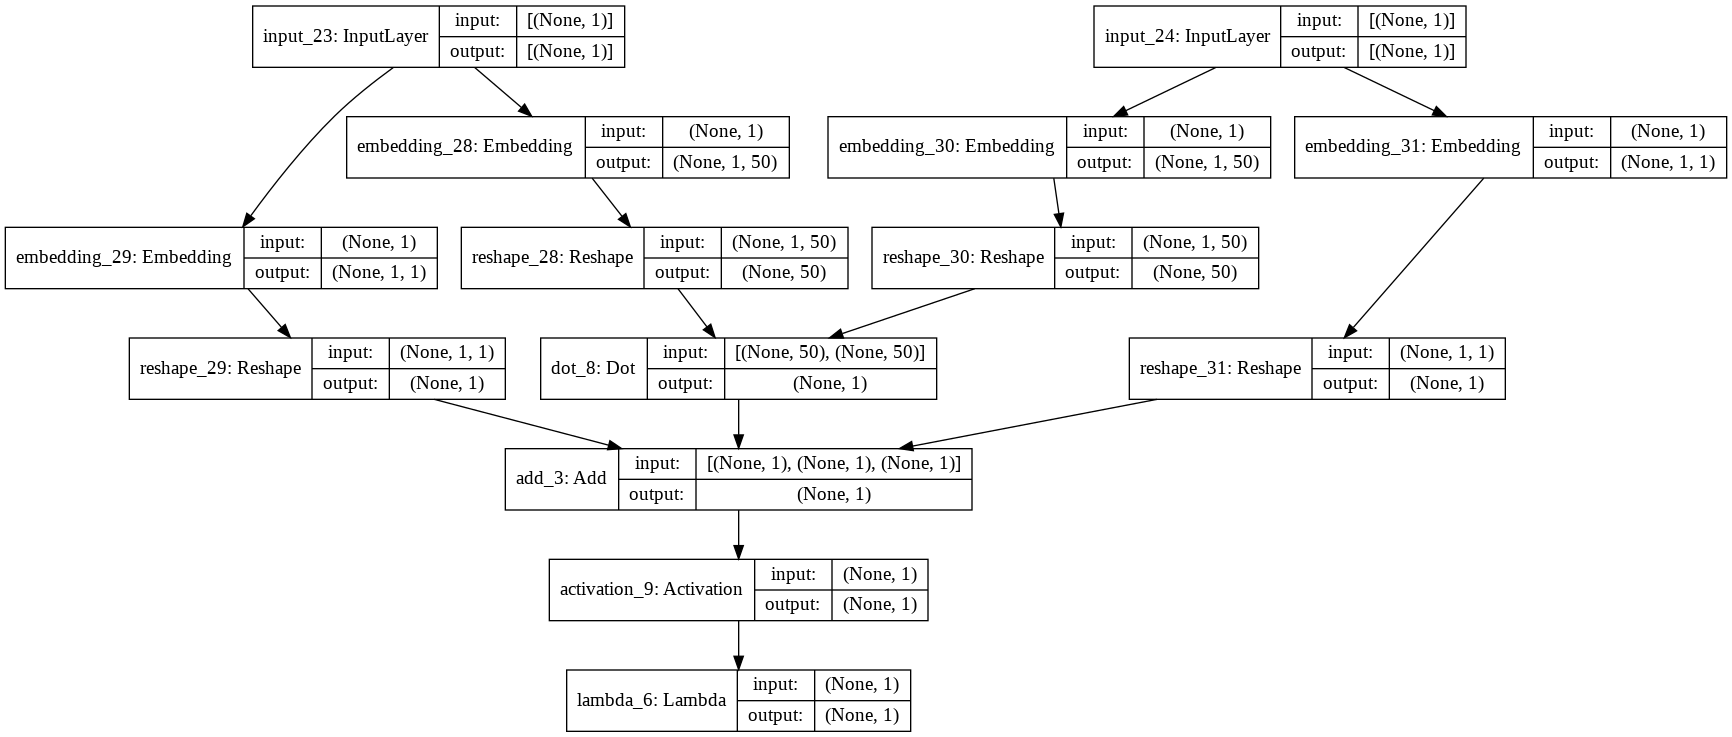

In [85]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='mod2.png', show_shapes=True, show_layer_names=True)

In [86]:
from keras.layers import Concatenate, Dense, Dropout
def RecommenderNet(n_users, n_movies, n_factors, min_rating, max_rating):
    user = Input(shape=(1,))
    u = EmbeddingLayer(n_users, n_factors)(user)
    
    movie = Input(shape=(1,))
    m = EmbeddingLayer(n_movies, n_factors)(movie)
    
    x = Concatenate()([u, m])
    x = Dropout(0.05)(x)
    
    x = Dense(10, kernel_initializer='he_normal')(x)
    x = Activation('relu')(x)
    x = Dropout(0.5)(x)
    
    x = Dense(1, kernel_initializer='he_normal')(x)
    x = Activation('sigmoid')(x)
    x = Lambda(lambda x: x * (max_rating - min_rating) + min_rating)(x)
    model = Model(inputs=[user, movie], outputs=x)
    opt = Adam(learning_rate=0.001)
    model.compile(loss='mean_squared_error', optimizer=opt)
    return model

In [87]:
model = RecommenderNet(n_users, n_movies, n_factors, min_rating, max_rating)
model.summary()

Model: "model_12"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_25 (InputLayer)           [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_26 (InputLayer)           [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding_32 (Embedding)        (None, 1, 50)        30500       input_25[0][0]                   
__________________________________________________________________________________________________
embedding_33 (Embedding)        (None, 1, 50)        486200      input_26[0][0]                   
___________________________________________________________________________________________

In [88]:
history = model.fit(x=X_train_array, y=y_train, batch_size=64, epochs=5,
                    verbose=1, validation_data=(X_test_array, y_test))

Epoch 1/5
1418/1418 [==============================] - 8s 5ms/step - loss: 1.0386 - val_loss: 0.7913
Epoch 2/5
1418/1418 [==============================] - 6s 4ms/step - loss: 0.7596 - val_loss: 0.7806
Epoch 3/5
1418/1418 [==============================] - 6s 4ms/step - loss: 0.7197 - val_loss: 0.7803
Epoch 4/5
1418/1418 [==============================] - 6s 4ms/step - loss: 0.7089 - val_loss: 0.7856
Epoch 5/5
1418/1418 [==============================] - 6s 4ms/step - loss: 0.6933 - val_loss: 0.7808


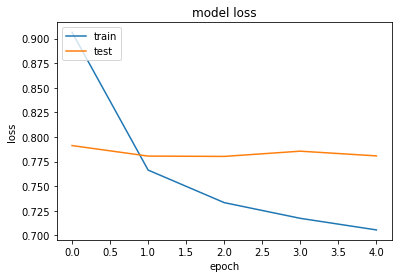

In [89]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "test"], loc="upper left")
plt.show()

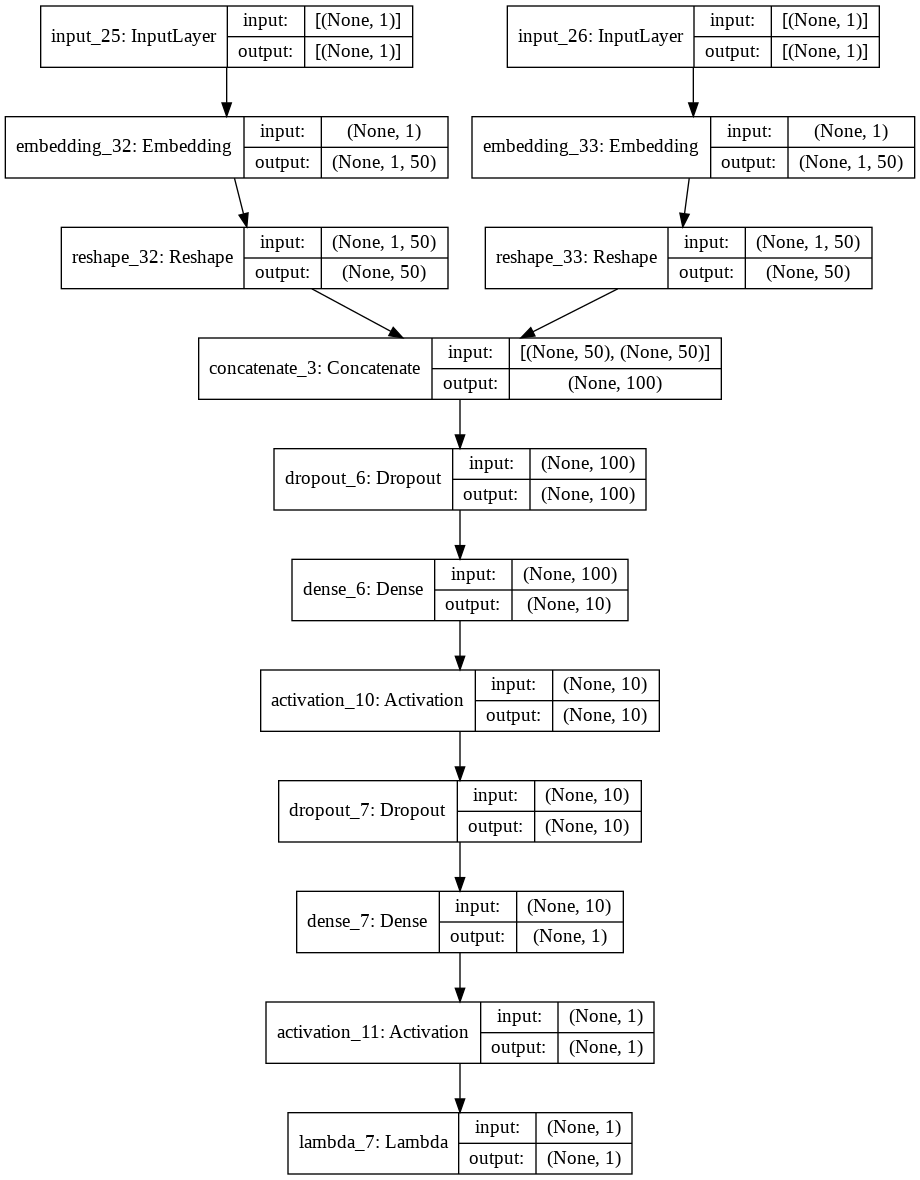

In [90]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='mod3.png', show_shapes=True, show_layer_names=True)